# Trial phase characterization

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase, broader_label

one = ONE(base_url='https://alyx.internationalbrainlab.org')

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmp68rago02/cache.zip Bytes: 120030504


100%|██████████| 114.47000885009766/114.47000885009766 [01:15<00:00,  1.52it/s]


## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Load data

List design matrices' eids

In [3]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

In [4]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mouse_name in enumerate(mouse_names):
    # Save results per mouse
    matrix_all[mouse_name] = {}
    session_all[mouse_name] = {}
    matrix_all_unnorm[mouse_name] = {}

for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        mouse_name = mat[37:]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        session_start = list(session_trials['stimOn_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]
        
        filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
                
        big_design_matrix = pickle.load(open(filename, "rb"))
        design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
        design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
        design_matrix = design_matrix.dropna()
    
        # Keep only first 90 trials
        design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
        unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
        training_set = np.array(design_matrix[var_names]).copy() 
        
        if len(training_set) > 0:
            # Standardization using StandardScaler
            scaler = StandardScaler()
            standardized = scaler.fit_transform(training_set)
            # Normalize between 0 and 1
            normalizer = Normalizer().fit(standardized)
            normalized = normalizer.transform(standardized)
            
            matrix_all[mouse_name][session] = normalized
            session_all[mouse_name][session] = unbiased_trials    
            matrix_all_unnorm[mouse_name][session] = design_matrix
            
        else:
            print(session)
    else:
        print(mat)

local md5 mismatch on dataset: churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL049/2020-01-11/001/alf/_ibl_trials.stimOff_times.npy: 100%|██████████| 4.60k/4.60k [00:00<00:00, 13.2kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.26k/5.26k [00:00<00:00, 15.3kB/s]


_
poch_DY_013.png_


local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-08/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.53k/6.53k [00:00<00:00, 8.91kB/s]


portances.svg_


local md5 mismatch on dataset: cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS023/2019-12-06/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.35k/5.35k [00:00<00:00, 16.1kB/s]
local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-03/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 4.38k/4.38k [00:00<00:00, 13.2kB/s]


lls_
_
poch_CSHL060.png_
_matrix_


local md5 mismatch on dataset: cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/cortexlab/Subjects/KS014/2019-12-07/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 5.38k/5.38k [00:00<00:00, 15.6kB/s]


1b61b7f2-a599-4e40-abd6-3e758d2c9e25
_


## Concatenate sessions of the same animal

In [5]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)

Need to figure why less animals/sessions!!!!!!!!!!!!!!!

In [67]:
def plot_features_per_epoch(use_data, hue, label, order, filename):
    
    bins_df = bins_per_trial_phase(use_data, session_trials)
    bins_df = bins_df.rename(columns={0: 'Bin'})
    new_df = use_data.merge(bins_df, on='Bin')
    # melted = pd.melt(new_df, id_vars=['Bin', label, 'Trial'], value_vars=np.array(new_df.keys()[1:-1]))

    # new_df['broader_label'] = new_df['label']
    # new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
    # new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
    # new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
    # new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
    # new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
    # new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
    # new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
    # new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
    # new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'

    new_df['broader_label'] = new_df['label']
    new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Quiescence'
    new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'ITI'
    new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'ITI'
    
    
    new_df['side'] = np.sign(new_df['signed_contrast'])

    " Plots "
    # Plot some variables
    first_vars = ['avg_wheel_vel',
    'pupil_diameter',
    'whisker_me',
    'nose_speed',
    'l_paw_speed',
    'pupil_speed',
    'Lick count']

    fig, ax = plt.subplots(nrows=len(first_vars) , ncols=1, sharex=False, sharey=False, figsize=[10, 20])
    plt.rc('font', size=12)

    for v, var in enumerate(first_vars):
        use_data = new_df[['Bin', label, var, 'correct', 'side', 'choice']]
        
        sns.barplot(y=var, x=label, data=use_data, hue=hue, ax=ax[v], ci=95, palette='plasma', order=order)
        ax[v].set_xlabel('Mean')
        ax[v].set_xticklabels(order, rotation=30)

    plt.tight_layout()
    plt.show()

    pos_vars = [ 'left_X',
    'left_Y',
    'pupil_X',
    'pupil_Y',]
    fig, ax = plt.subplots(nrows=2 , ncols=2, sharex=False, sharey=False, figsize=[14, 10])
    plt.rc('font', size=12)

    for v, var in enumerate(pos_vars):
        
        use_data = new_df[['Bin', label, var, 'correct', 'side', 'choice']]

        if var == 'left_X':
            axis = ax[0, 0]
        elif var == 'left_Y':
            axis = ax[0, 1]
        elif var == 'pupil_X':
            axis = ax[1, 0]
        elif var == 'pupil_Y':
            axis = ax[1, 1]
            
        sns.barplot(y=var, x=label, data=use_data, hue=hue, ax=axis, ci=95, palette='plasma', order=order)
        axis.set_xlabel('Mean')
        axis.set_xticklabels(order, rotation=30)
        
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()


def stats_features_per_epoch(use_data, hue, label):
    
    bins_df = bins_per_trial_phase(use_data, session_trials)
    bins_df = bins_df.rename(columns={0: 'Bin'})
    new_df = use_data.merge(bins_df, on='Bin')
    new_df['side'] = np.sign(new_df['signed_contrast'])
    new_df.loc[new_df['side']==0] = np.nan

    new_df['broader_label'] = new_df['label']
    new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Quiescence'
    new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'ITI'
    new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'ITI'
    new_df = new_df.dropna()
    
    trial_epochs = new_df[label].unique()
    hues = new_df[hue].unique()
    vars = new_df.keys()[0:11]

    p_values = pd.DataFrame(columns=['var', 'epoch', 'significance'])
    for v, var in enumerate(vars):
        var_data = new_df[['Bin', label, var, hue]]
        
        for e, epoch in enumerate(trial_epochs):
            epoch_data = var_data.loc[var_data[label]==epoch]
            
            group_1 = epoch_data.loc[epoch_data[hue]==hues[0], var]
            group_2 = epoch_data.loc[epoch_data[hue]==hues[1], var]
            
            _, p_v = stats.ttest_ind(group_1, group_2)

            # Save results
            p_value = pd.DataFrame(columns=['var', 'epoch', 'significance'], index=range(1))
            p_value['var'] = var
            p_value['epoch'] = epoch
            if (np.nanmean(group_2) > np.nanmean(group_1)) and (p_v < 0.05):
                p_value['significance'] = 'Significantly higher'
            elif (np.nanmean(group_2) < np.nanmean(group_1)) and (p_v < 0.05):
                p_value['significance'] = 'Significantly smaller'
            elif p_v >= 0.05:
                p_value['significance'] = 'Non significant'
                
            # Append
            p_values = pd.concat([p_values, p_value], ignore_index=True)
    
    # Plot 
    if hue in ['choice', 'side']:
        hue_names = np.array(['left', 'right'])
        hue_numbers = np.array([-1.0, 1.0])
    elif hue == 'correct':
        hue_names = np.array(['correct', 'incorrect'])
        hue_numbers = np.array([1., 0.])
    sns.catplot(y='var', x='significance', hue='epoch', data=p_values, 
    order=['Non significant', 'Significantly higher', 'Significantly smaller'],
    height=5, aspect=2)

    plt.title(str('Modulation by ' + hue + ' ' + str(hue_names[np.where(hue_numbers==hues[1])]) + 
                ' - ' + str(hue_names[np.where(hue_numbers==hues[0])])))
    plt.show()
            
    return p_values   

    
def stats_features_per_epoch_sess(idxs, session_all, matrix_all, matrix_all_unnorm, hue, label):
    
    p_values = pd.DataFrame(columns=['mouse', 'var', 'epoch', 'significance'])
    
    for m, mat in enumerate(idxs):
        if len(mat) > 35: 
                
            # Trials data
            session = mat[0:36]
            # Mouse name
            mouse_name = mat[37:]
            
            print('Testing mouse ' + mouse_name)

            # Get mouse data
            session_trials = session_all[mouse_name][session]
            design_matrix = matrix_all[mouse_name][session]
            unnorm_mat = matrix_all_unnorm[mouse_name][session]
            
            if len(np.shape(design_matrix)) > 2:
                design_matrix = design_matrix[0]
                session_trials = session_trials[0]
                unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
            " Prepare design matrix "
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix
            bins = unnorm_mat['Bin']
            design_matrix_heading['Bin'] = bins
            
            design_matrix_heading['Lick count'] = gaussian_filter1d(design_matrix_heading['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
            #plt.hist(use_data['Lick count'])
            design_matrix_heading['avg_wheel_vel'] = np.abs(design_matrix_heading['avg_wheel_vel'])

            " Prepare data for plotting "
            bins_df = bins_per_trial_phase(design_matrix_heading, session_trials)
            bins_df = bins_df.rename(columns={0: 'Bin'})
            new_df = design_matrix_heading.merge(bins_df, on='Bin')
            new_df['side'] = np.sign(new_df['signed_contrast'])
            new_df.loc[new_df['side']==0] = np.nan

            new_df = broader_label(new_df)
            new_df = new_df.dropna()
            
            trial_epochs = new_df[label].unique()
            hues = new_df[hue].unique()
            vars = new_df.keys()[0:11]

            for v, var in enumerate(vars):
                var_data = new_df[['Bin', label, var, hue]]
                
                for e, epoch in enumerate(trial_epochs):
                    epoch_data = var_data.loc[var_data[label]==epoch]
                    
                    group_1 = epoch_data.loc[epoch_data[hue]==hues[0], var]
                    group_2 = epoch_data.loc[epoch_data[hue]==hues[1], var]
                    
                    _, p_v = stats.ttest_ind(group_1, group_2)

                    # Save results
                    p_value = pd.DataFrame(columns=['mouse', 'var', 'epoch', 'significance'], index=range(1))
                    p_value['mouse'] = mouse_name
                    p_value['var'] = var
                    p_value['epoch'] = epoch
                    if (np.nanmean(group_2) > np.nanmean(group_1)) and (p_v < 0.05):
                        p_value['significance'] = 'Significantly higher'
                    elif (np.nanmean(group_2) < np.nanmean(group_1)) and (p_v < 0.05):
                        p_value['significance'] = 'Significantly smaller'
                    elif p_v >= 0.05:
                        p_value['significance'] = 'Non significant'
                        
                    # Append
                    p_values = pd.concat([p_values, p_value], ignore_index=True)
            
    return p_values 


def plot_features(use_data, session_trials, label):

    # use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
    #plt.hist(use_data['Lick count'])
    use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
    
    # Get trial phase
    bins_df = bins_per_trial_phase(use_data, session_trials)
    bins_df = bins_df.rename(columns={0: 'Bin'})
    new_df = design_matrix.merge(bins_df, on='Bin')
    # melted = pd.melt(new_df, id_vars=['Bin', label, 'Trial'], value_vars=np.array(var_names))
    
    # Get broader labels
    new_df = broader_label(new_df)
    # trial_epochs = new_df['label'].unique()

    # Plot some variables
    first_vars = ['avg_wheel_vel',
    'pupil_diameter',
    'whisker_me',
    'nose_speed',
    'l_paw_speed',
    'pupil_speed',
    'Lick count']

    if label == 'label':
        label_order = ['Quiescence', 'Stimulus left', 'Stimulus right', 'Left choice',
                       'Right choice', 'Correct feedback', 'Incorrect feedback', 'ITI_correct', 'ITI_incorrect']
    elif label == 'broader_label':
        label_order = ['Quiescence', 'Stimulus', 'Choice', 'ITI']
        
    fig, ax = plt.subplots(nrows=len(first_vars) , ncols=1, sharex=False, sharey=False, figsize=[8, 20])
    plt.rc('font', size=12)

    for v, var in enumerate(first_vars):
        use_data = new_df[['Bin', label, var]]
        sns.barplot(y=var, x=label, data=use_data, ax=ax[v], palette='plasma', order = label_order)
        ax[v].set_xlabel('Mean')
        ax[v].set_xticklabels(label_order, rotation=30)

    plt.tight_layout()
    plt.show()



## Loop through animals

In [6]:
broader = True
var = 'broader_label'

all_animals_df = pd.DataFrame(columns=np.concatenate(([var], var_names)))

for m, mat in enumerate(idxs[0:10]):
    if len(mat) > 35: 
        
        session_df = pd.DataFrame(columns=np.concatenate(([var], var_names)))
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]
        
        print('Fitting mouse ' + mouse_name)

        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]

        " Prepare design matrix "
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix
        bins = unnorm_mat['Bin']
        design_matrix_heading['Bin'] = bins
        
        # Absolute wheel velocity
        design_matrix_heading['avg_wheel_vel'] = np.abs(design_matrix_heading['avg_wheel_vel'])
        
        unnorm_mat['avg_wheel_vel'] = np.abs(unnorm_mat['avg_wheel_vel'])

        # # Get trial phase
        # bins_df = bins_per_trial_phase(design_matrix_heading, session_trials)
        # bins_df = bins_df.rename(columns={0: 'Bin'})
        # new_df = design_matrix_heading.merge(bins_df, on='Bin')

        # Get trial phase
        bins_df = bins_per_trial_phase(unnorm_mat, session_trials)
        bins_df = bins_df.rename(columns={0: 'Bin'})
        new_df = unnorm_mat.merge(bins_df, on='Bin')

        # Get broader labels
        new_df = broader_label(new_df)

        # Average per trial epoch
        session_df = new_df.groupby(var)[var_names].mean().reset_index()
        
        # Save results
        if m == 0:
            all_animals_df = session_df.copy()
        else:
            all_animals_df = all_animals_df.append(session_df)
        

Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse ZFM-02369


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse SWC_061


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse CSHL049


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse NR_0019


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse SWC_053


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse CSHL058


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse ZFM-01936


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse SWC_043


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse KS023


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

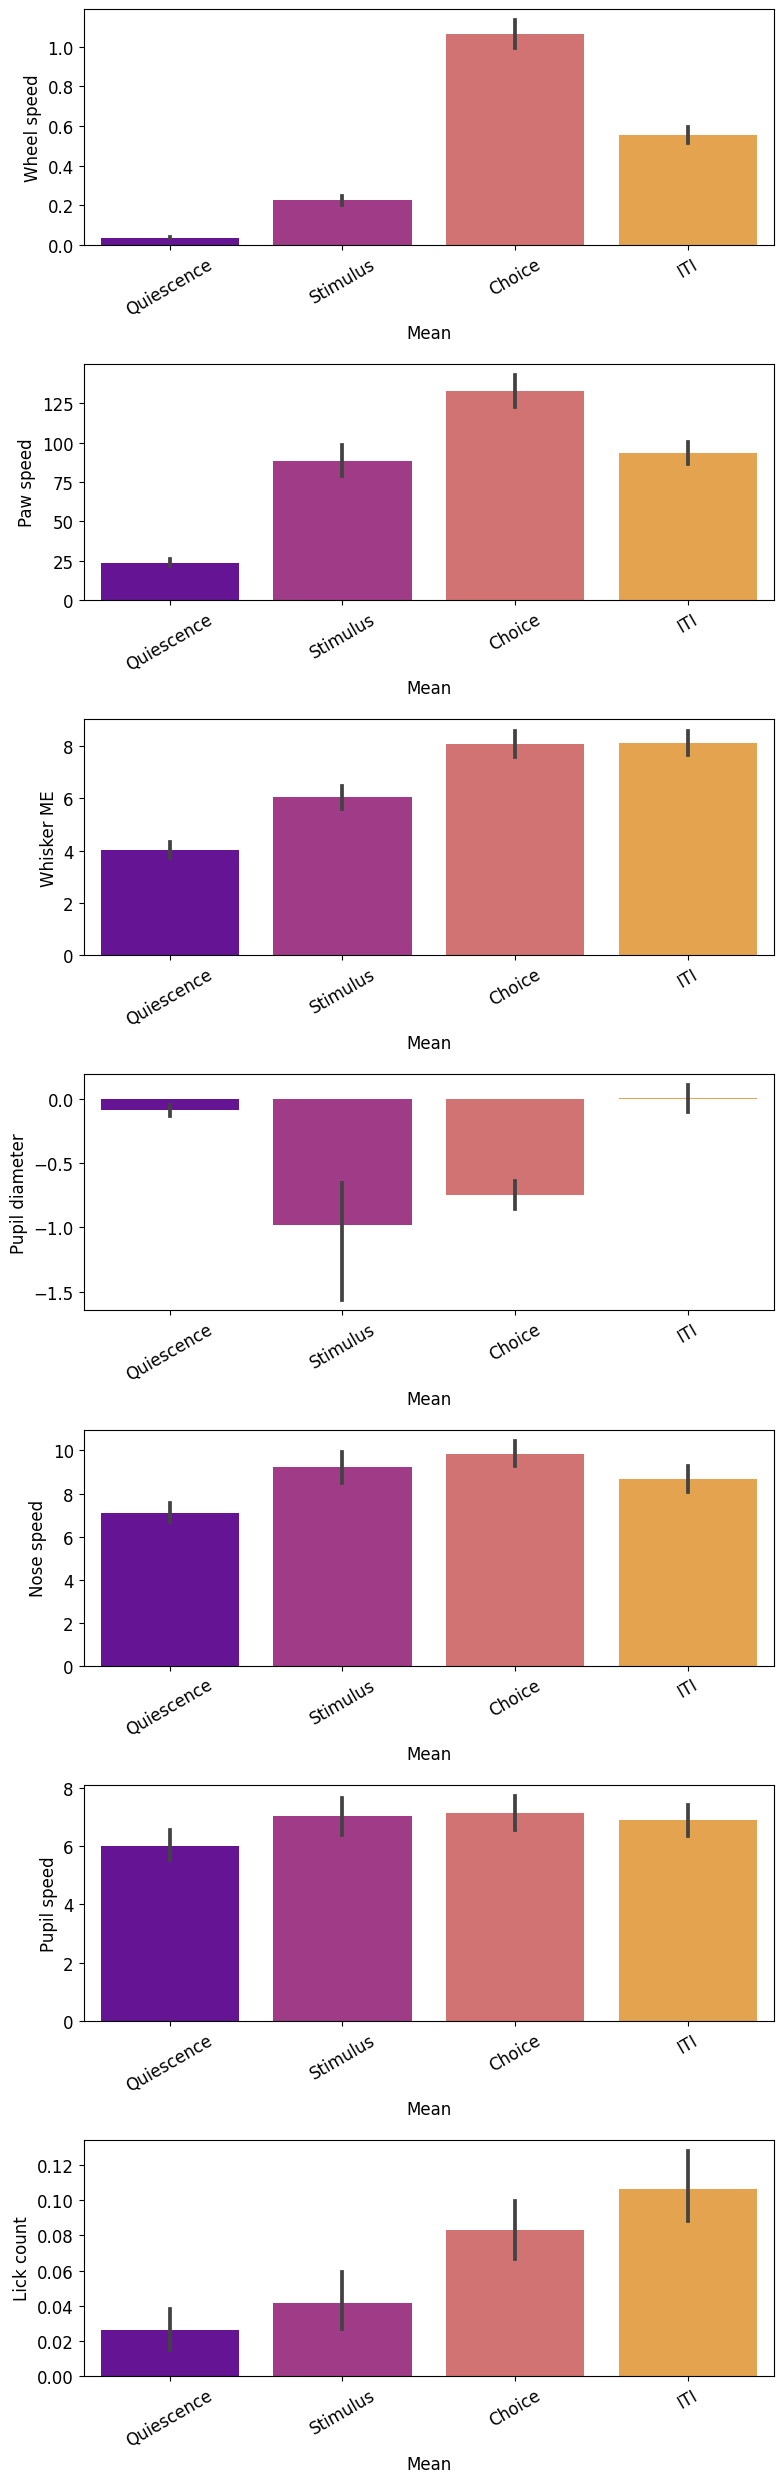

In [55]:
data = pd.melt(all_animals_df, id_vars=[var], value_vars=np.array(var_names))
use_vars = ['avg_wheel_vel',  'l_paw_speed',
 'whisker_me',
 'pupil_diameter',
 'nose_speed',
 'pupil_speed',
 'Lick count']
use_names = ['Wheel speed', 'Paw speed', 'Whisker ME', 
             'Pupil diameter',
            'Nose speed', 
            'Pupil speed', 'Lick count']

# plot_order = data.groupby('variable')['value'].mean().sort_values(ascending=False).index.values
fig, ax = plt.subplots(nrows=len(use_vars) , ncols=1, sharex=False, sharey=False, figsize=[8, 25])
plt.rc('font', size=12)
label_order = ['Quiescence', 'Stimulus', 'Choice', 'ITI']

for v, vari in enumerate(use_vars):
    use_data = use_data.replace(vari, use_names[v])
    use_data = data.loc[data['variable']==vari]
    sns.barplot(y='value', x=var, data=use_data, ax=ax[v], palette='plasma', order = label_order)
    ax[v].set_xlabel('Mean')
    ax[v].set_ylabel(use_names[v])
    ax[v].set_xticklabels(label_order, rotation=30)
    
plt.tight_layout()

# Plot a single session

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

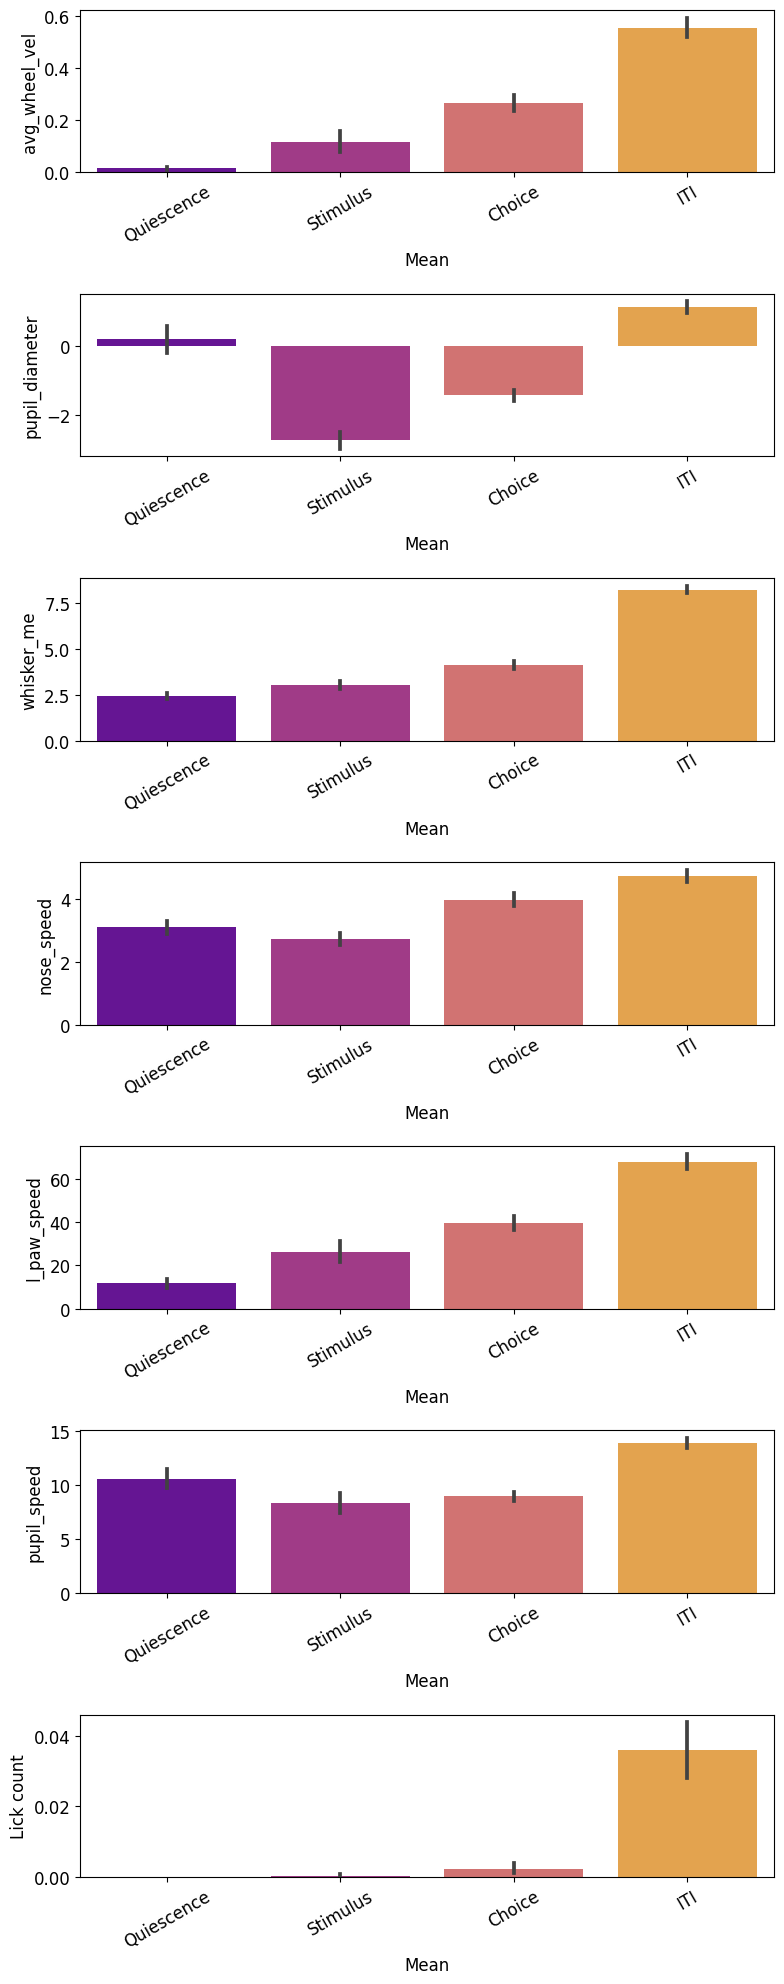

In [68]:
plot_features(design_matrix, session_trials, label)

In [61]:
label = 'broader_label'

def plot_features(use_data, session_trials, label):


    use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
    #plt.hist(use_data['Lick count'])
    use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
    
    # Get trial phase
    bins_df = bins_per_trial_phase(use_data, session_trials)
    bins_df = bins_df.rename(columns={0: 'Bin'})
    new_df = design_matrix.merge(bins_df, on='Bin')
    # melted = pd.melt(new_df, id_vars=['Bin', label, 'Trial'], value_vars=np.array(var_names))
    
    # Get broader labels
    new_df['broader_label'] = new_df['label']
    # new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
    # new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
    # new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
    # new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
    # new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
    # new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
    # new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
    # new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
    # new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'
    
    new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Quiescence'
    new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'ITI'
    new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'ITI'
    new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'ITI'
    new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'ITI'
    
    # trial_epochs = new_df['label'].unique()

    # Plot some variables
    first_vars = ['avg_wheel_vel',
    'pupil_diameter',
    'whisker_me',
    'nose_speed',
    'l_paw_speed',
    'pupil_speed',
    'Lick count']

    if label == 'label':
        label_order = ['Quiescence', 'Stimulus left', 'Stimulus right', 'Left choice',
                       'Right choice', 'Correct feedback', 'Incorrect feedback', 'ITI_correct', 'ITI_incorrect']
    elif label == 'broader_label':
        label_order = ['Quiescence', 'Stimulus', 'Choice', 'ITI']
        
    fig, ax = plt.subplots(nrows=len(first_vars) , ncols=1, sharex=False, sharey=False, figsize=[8, 20])
    plt.rc('font', size=12)

    for v, var in enumerate(first_vars):
        use_data = new_df[['Bin', label, var]]
        sns.barplot(y=var, x=label, data=use_data, ax=ax[v], palette='plasma', order = label_order)
        ax[v].set_xlabel('Mean')
        ax[v].set_xticklabels(label_order, rotation=30)

    plt.tight_layout()
    plt.show()


In [37]:
# use_data = design_matrix.copy()  # To keep the column names
# use_data[var_names] = matrix_all[mat][0]

use_data = design_matrix.copy()
use_data['Lick count'] = gaussian_filter1d(use_data['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
#plt.hist(use_data['Lick count'])
use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])


## Trial phase

In [56]:
bins_df = bins_per_trial_phase(use_data, session_trials)
bins_df = bins_df.rename(columns={0: 'Bin'})
new_df = design_matrix.merge(bins_df, on='Bin').drop(columns=['correct', 'signed_contrast', 'choice'])
melted = pd.melt(new_df, id_vars=['Bin', label, 'Trial'], value_vars=np.array(new_df.keys()[1:-2]))

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

## Trial epoch

In [58]:
new_df['broader_label'] = new_df['label']
new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Pre-choice'
new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'Post-choice'
new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'Post-choice'

<AxesSubplot: xlabel='label', ylabel='value'>

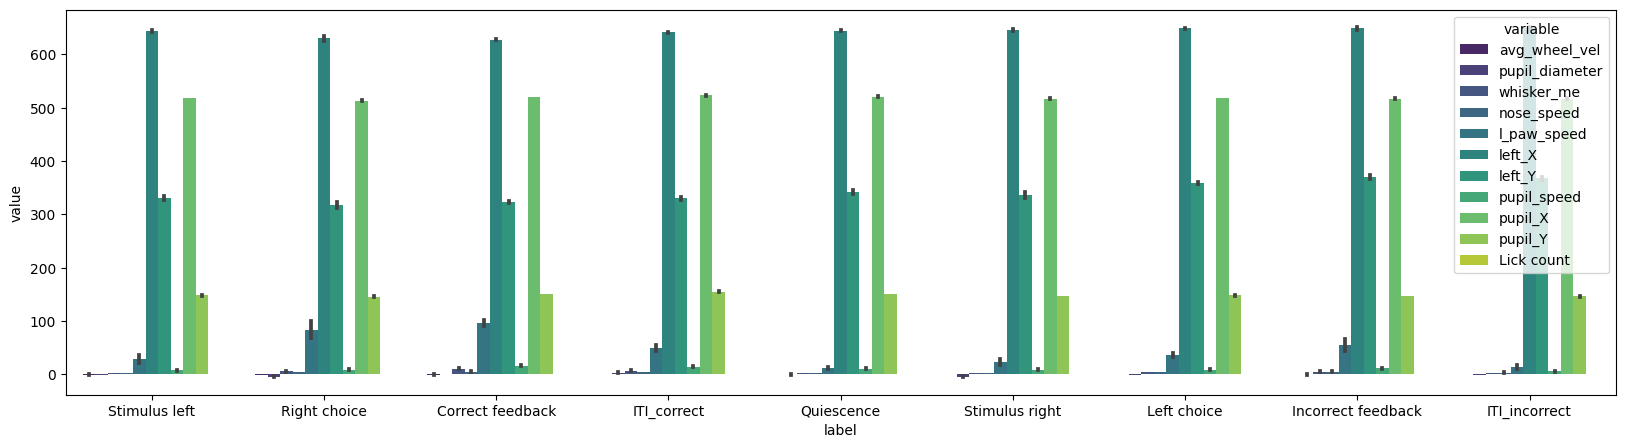

In [59]:
fig, ax = plt.subplots(figsize=[20, 5])
sns.barplot(hue='variable', y='value', x='label', data=melted, palette='viridis')
#plt.ylim([-5, 5])

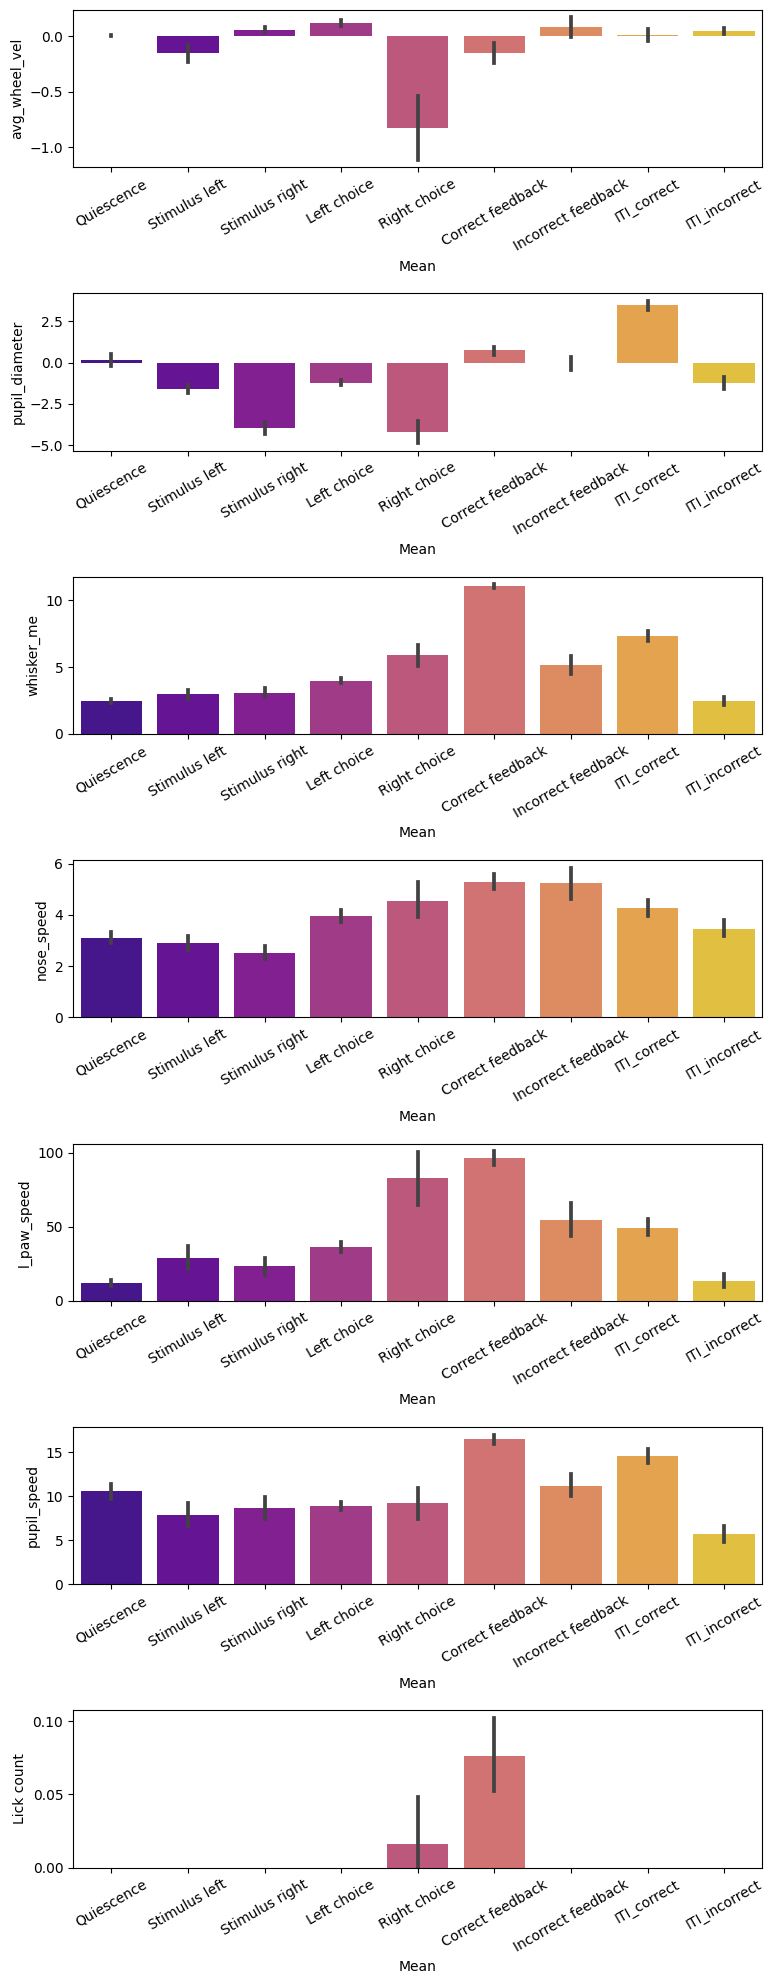

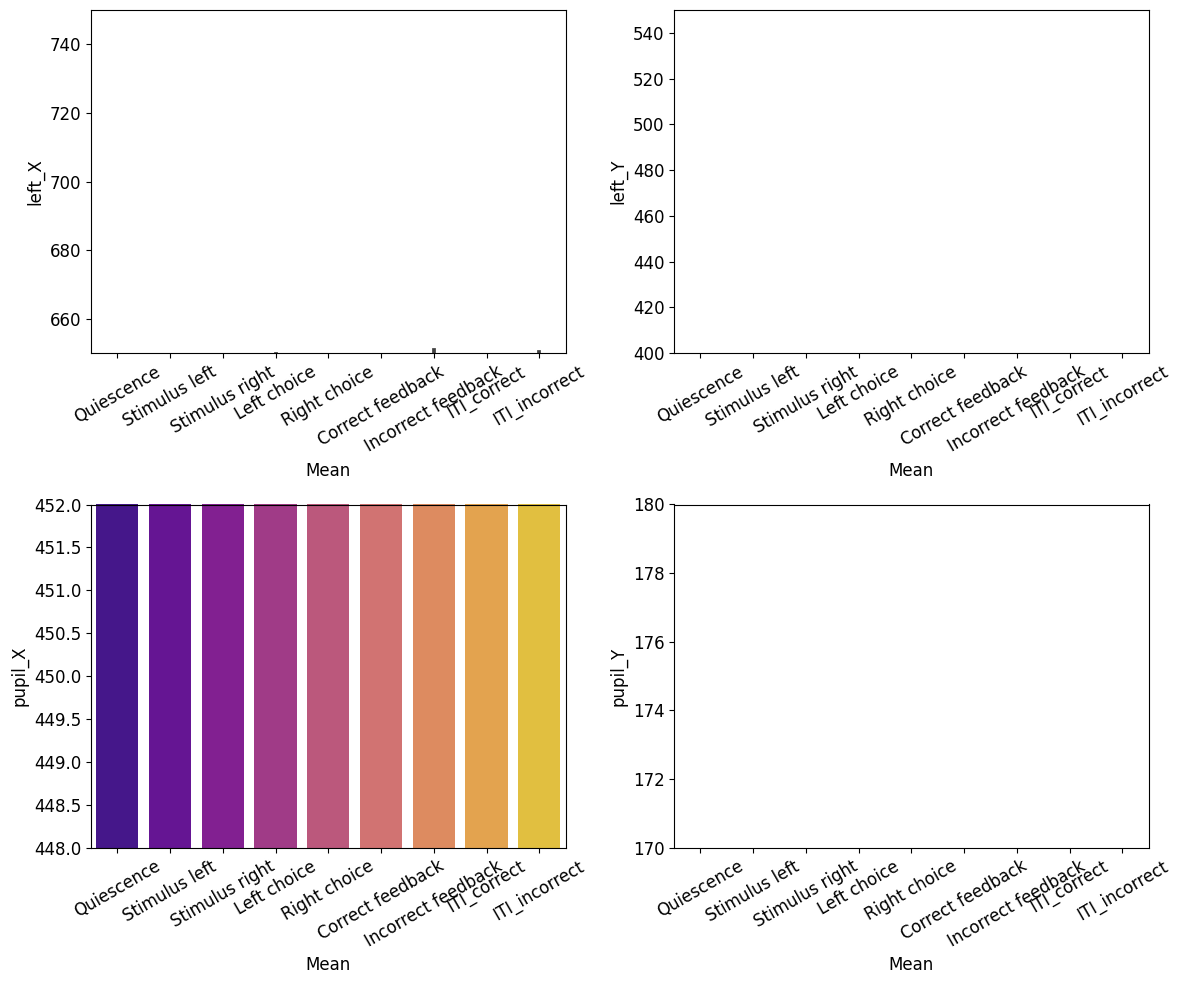

In [60]:
trial_epochs = new_df['label'].unique()

# Plot some variables
first_vars = ['avg_wheel_vel',
 'pupil_diameter',
 'whisker_me',
 'nose_speed',
 'l_paw_speed',
 'pupil_speed',
 'Lick count']

fig, ax = plt.subplots(nrows=len(first_vars) , ncols=1, sharex=False, sharey=False, figsize=[8, 20])
plt.rc('font', size=12)

for v, var in enumerate(first_vars):
    use_data = new_df[['Bin', 'label', var]]
    sns.barplot(y=var, x='label', data=use_data, ax=ax[v], palette='plasma', order = ['Quiescence', 'Stimulus left', 'Stimulus right', 
                                                                                      'Left choice', 'Right choice', 'Correct feedback', 
                                                                                      'Incorrect feedback', 'ITI_correct', 'ITI_incorrect'])
    ax[v].set_xlabel('Mean')
    ax[v].set_xticklabels(['Quiescence', 'Stimulus left', 'Stimulus right', 'Left choice', 'Right choice', 'Correct feedback', 
                                                                                      'Incorrect feedback', 'ITI_correct', 'ITI_incorrect'], rotation=30)

    #ax[v].set_ylim([np.min(use_data[var]), np.max(use_data[var])])
plt.tight_layout()
plt.show()

pos_vars = [ 'left_X',
 'left_Y',
 'pupil_X',
 'pupil_Y',]
fig, ax = plt.subplots(nrows=2 , ncols=2, sharex=False, sharey=False, figsize=[12, 10])
plt.rc('font', size=12)

for v, var in enumerate(pos_vars):
    
    use_data = new_df[['Bin', 'label', var]]

    if var == 'left_X':
        axis = ax[0, 0]
        ymin = 650
        ymax = 750
    elif var == 'left_Y':
        axis = ax[0, 1]
        ymin = 400
        ymax = 550
    elif var == 'pupil_X':
        axis = ax[1, 0]
        ymin = 448
        ymax = 452
    elif var == 'pupil_Y':
        axis = ax[1, 1]
        ymin = 170
        ymax = 180
        
    sns.barplot(y=var, x='label', data=use_data, ax=axis, palette='plasma', order = ['Quiescence', 'Stimulus left', 'Stimulus right', 
                                                                                    'Left choice', 'Right choice', 'Correct feedback', 
                                                                                    'Incorrect feedback', 'ITI_correct', 'ITI_incorrect'])
    axis.set_xlabel('Mean')
    axis.set_xticklabels(['Quiescence', 'Stimulus left', 'Stimulus right', 'Left choice', 'Right choice', 'Correct feedback', 
                                                                                    'Incorrect feedback', 'ITI_correct', 'ITI_incorrect'], rotation=30)

    axis.set_ylim([ymin, ymax])
    
plt.tight_layout()
plt.show()